# Social media post caption semantic retrieval prototype

dataset: https://www.kaggle.com/prithvijaunjale/instagram-images-with-captions

- 1 of 2 proposed solutions
- based on Sentence-BERT, a transformer-based model, and on FAISS, Facebook's indexing and similarity search library
- post retrival times are around 0.05s - 0.07s / search on average, given circa 20K captions. This could be significantly improved by implementing GPU version of the Faiss package
- search results seem relevant, though no formal evaluation has been conducted

### Potential improvements:

- using a more diversified dataset that reflects the wealth of SM post topics nowadays
- dual (text-image) encoding can be employed, though Instagram posts captions don't always match images in meanings
- more information can be extracted from captions (e.g sentiment analysis, fact/event extractiom, etc.)

In [5]:
# install packages if not installed

!pip install sentence-transformers
!pip install textblob
!pip install faiss-cpu

In [122]:
# improt packages

import os
from PIL import Image
import re
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
import faiss
from pprint import pprint
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [77]:
# improt data

data = pd.read_csv("captions_csv.csv", memory_map = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20515 entries, 0 to 20514
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sr No       20515 non-null  int64 
 1   Image File  20515 non-null  object
 2   Caption     17100 non-null  object
dtypes: int64(1), object(2)
memory usage: 480.9+ KB


In [78]:
import gc

df = data[['Image File','Caption']]
df['jpg_path'] = "./img/" + df['Image File'] + ".jpg"

del data
gc.collect()

13773

In [79]:
# drop NAs and duplicates
df.dropna(inplace=True)
df.drop_duplicates(subset=['Caption'],inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


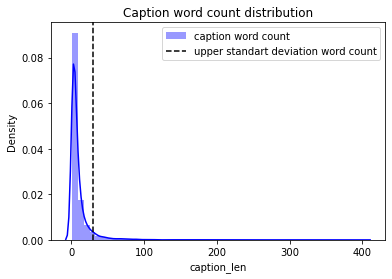

In [84]:
# plot word count distribution
# start by countning words
df['caption_len'] = df['Caption'].apply(lambda words: len(words.split()))
# calculate upper STD bound
plus_1_std_len = np.round(df['caption_len'].mean() + df['caption_len'].std()).astype(int)

sns.distplot(df['caption_len'], hist=True, kde=True, color='b', label='caption word count')
plt.axvline(x=plus_1_std_len, color='k', linestyle='--', label='upper standart deviation word count')
plt.title('Caption word count distribution'); plt.legend()
plt.show()


In [11]:
# define model for embedding 
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')
# generate embeddings
encoded_data = model.encode(df.Caption.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
# map faiss indices
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'img.index')

In [99]:
# define functions
# create "meta dictionary" to map data from database to search results 
def getCaption(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Caption'] = re.sub("(.{32})", "\\1\n", info['Caption'], 0, re.DOTALL)
    meta_dict['path'] = info['jpg_path']
    return meta_dict

# search query, including visualization
def searchText(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [getCaption(i) for i in top_k_ids]
    paths = [results[i]['path'] for i, e in enumerate(top_k_ids)]
    
    # visualize, assuming there are going to be 5 results
    imgs = [Image.open(path) for path in paths]
    fig, axes = plt.subplots(1, 5, figsize=(20,8))
    for i, ax in zip(range(5), axes.ravel()):
        ax.set_title(i)
        ax.imshow(imgs[i])
        ax.set_title(f"{paths[i]}\n\n{results[i]['Caption']}")
        ax.axis("off")
    plt.show()
    

>>>> Results in Total Time: 0.06705808639526367


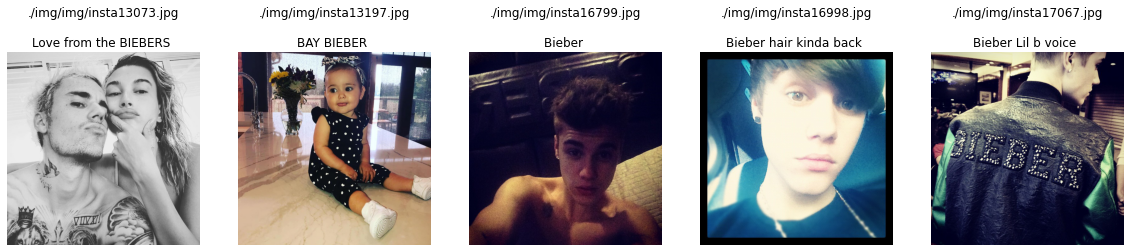

TypeError: 'NoneType' object is not iterable

In [109]:
# define query
query = "bieber"

# execute query
results = searchText(query, top_k = 5, index = index, model = model)

# visualize
for result in results:
    print('\t',str(result))

>>>> Results in Total Time: 0.0690920352935791


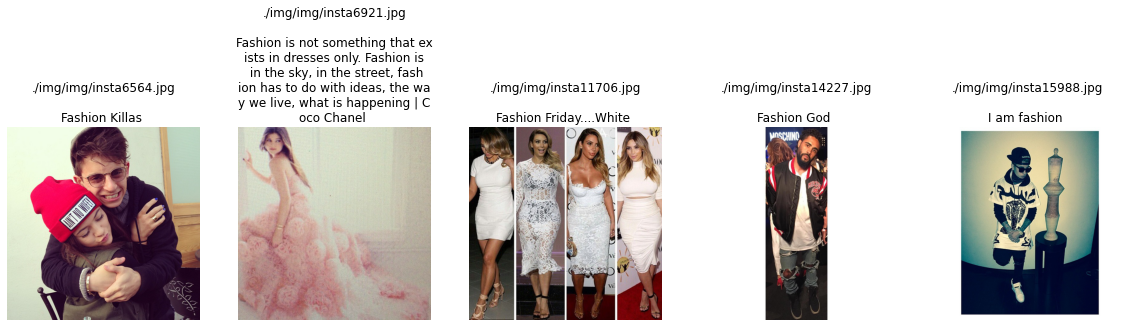

TypeError: 'NoneType' object is not iterable

In [112]:
# define query
query = "fashion"

# execute query
results = searchText(query, top_k = 5, index = index, model = model)

# visualize
for result in results:
    print('\t',str(result))

>>>> Results in Total Time: 0.04940342903137207


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129419 (\N{BUTTERFLY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127940 (\N{SURFER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


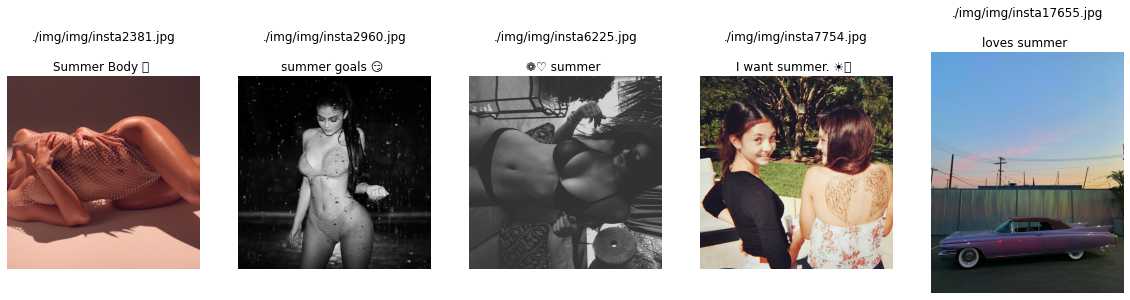

TypeError: 'NoneType' object is not iterable

In [113]:
# define query
query = "summer"

# execute query
results = searchText(query, top_k = 5, index = index, model = model)

# visualize
for result in results:
    print('\t',str(result))

>>>> Results in Total Time: 0.06696271896362305


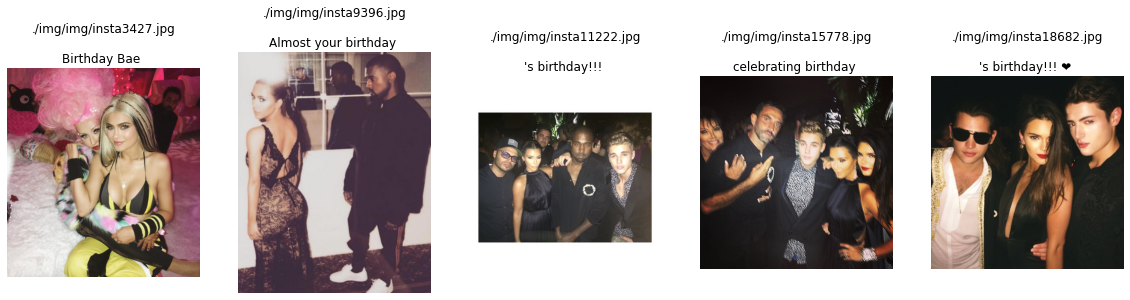

TypeError: 'NoneType' object is not iterable

In [114]:
# define query
query = "birthday"

# execute query
results = searchText(query, top_k = 5, index = index, model = model)

# visualize
for result in results:
    print('\t',str(result))

>>>> Results in Total Time: 0.06879329681396484


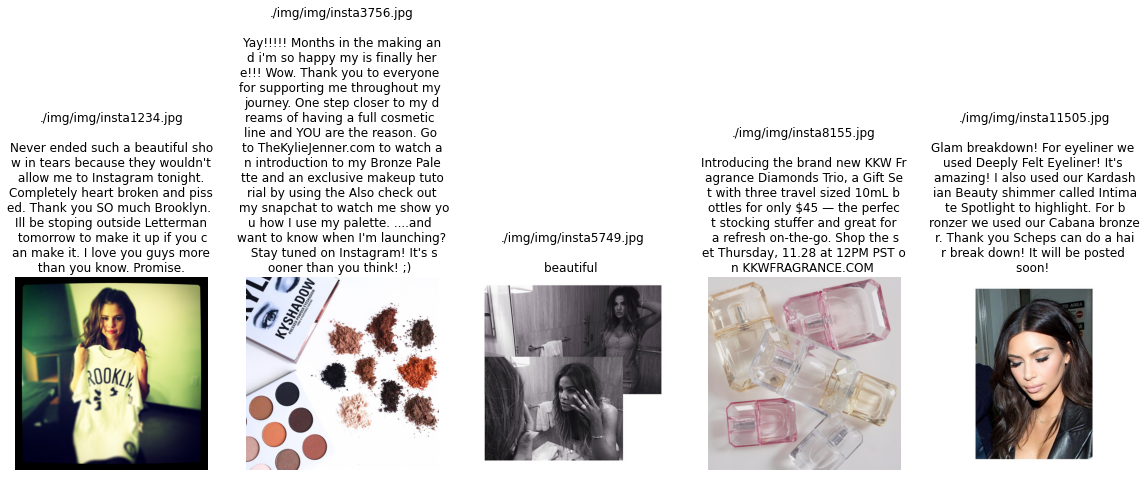

TypeError: 'NoneType' object is not iterable

In [121]:
# define query
query = "aesthetics"

# execute query
results = searchText(query, top_k = 5, index = index, model = model)

# visualize
for result in results:
    print('\t',str(result))